In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
# adata = sc.read(
#     filename="s4d8_quality_control.h5ad",
#     backup_url="https://figshare.com/ndownloader/files/40014331",
# )

In [3]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

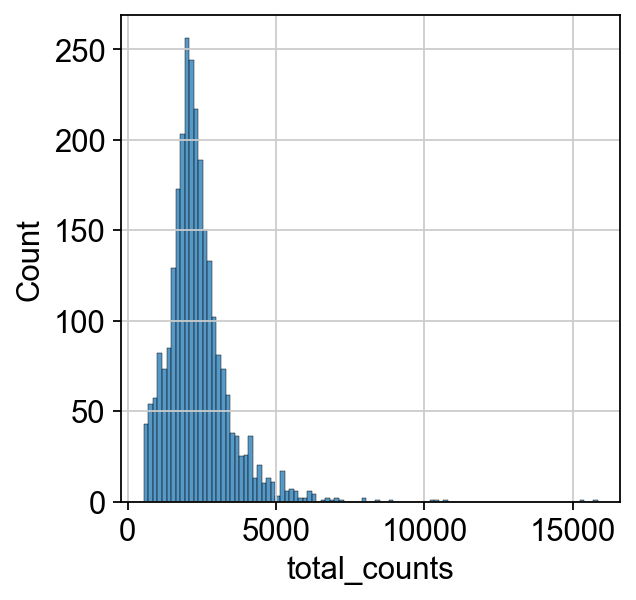

In [5]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [6]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.obsm["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata.obsm["log1p"] = sc.pp.log1p(adata.X, copy=True)

In [7]:
from scipy.stats import pearsonr
from tqdm import tqdm

def calculate_correlation(matrix1, matrix2):
    # Check if matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Input matrices must have the same shape")

    # Get the number of columns in the matrices
    num_columns = matrix1.shape[1]

    # Initialize an array to store correlations
    correlations = np.zeros(num_columns)

    # Calculate correlation for each column pair
    for i in tqdm(range(num_columns)):
        column1 = matrix1.getcol(i).toarray().flatten()
        column2 = matrix2.getcol(i).toarray().flatten()
        correlations[i] = pearsonr(column1, column2)[0]

    return correlations

In [8]:
correlations = calculate_correlation(adata.obsm["log1p_norm"], adata.obsm["log1p"])

  0%|                                                                                                                                                          | 0/32738 [00:00<?, ?it/s]/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32738/32738 [01:23<00:00, 390.96it/s]


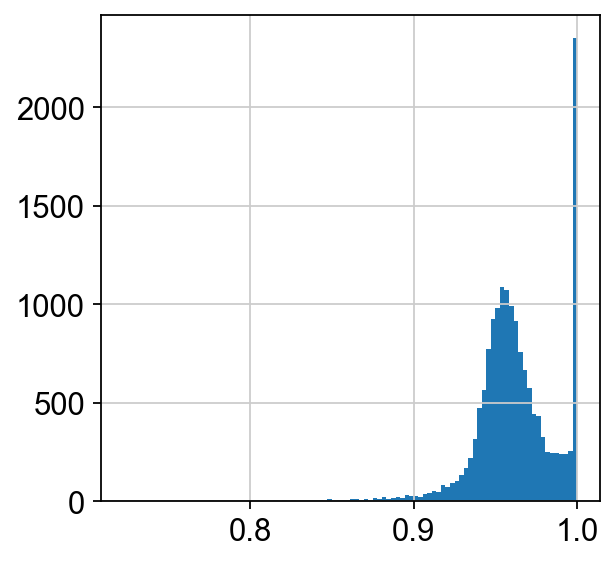

In [9]:
fig, ax = plt.subplots()
ax.hist(correlations, bins=100);

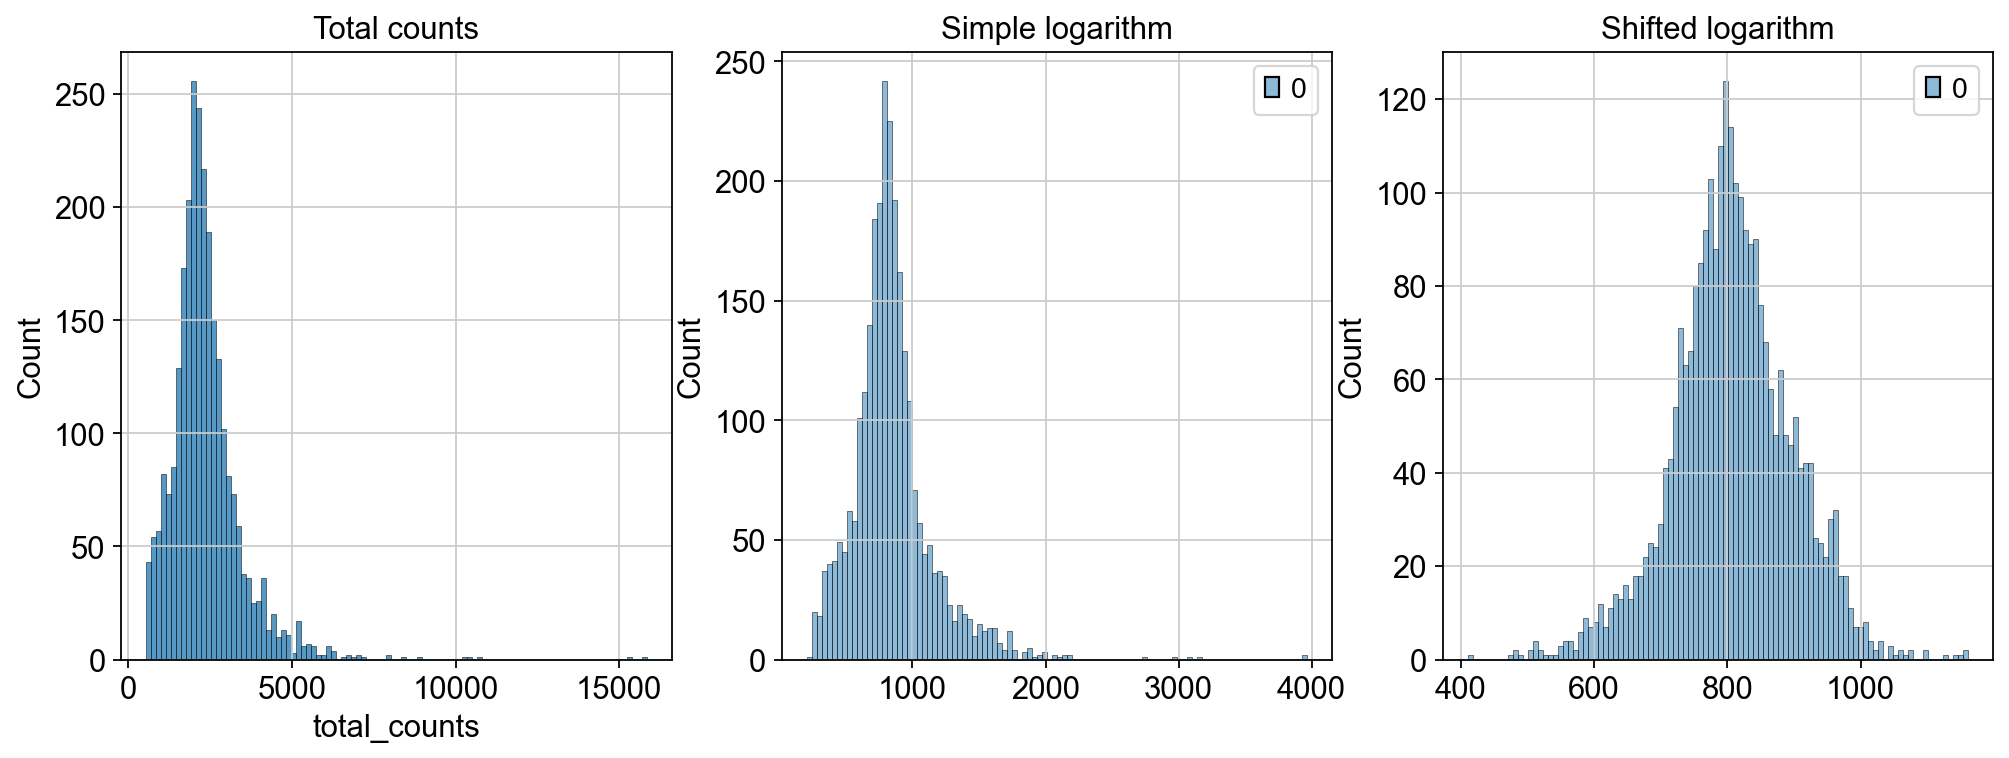

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.obsm["log1p"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Simple logarithm")
p3 = sns.histplot(adata.obsm["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[2])
axes[2].set_title("Shifted logarithm")
plt.show()

In [13]:
sc.pp.neighbors(adata, use_rep="log1p_norm", key_added="log1p_norm")
sc.tl.umap(adata, neighbors_key="log1p_norm")

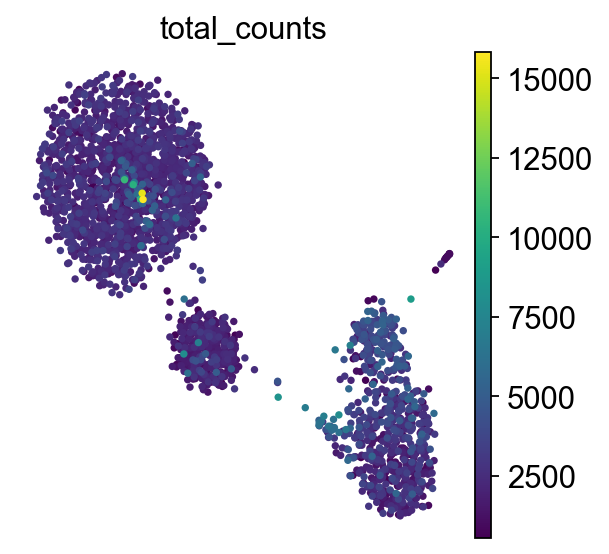

In [16]:
sc.pl.umap(adata, color="total_counts")

In [18]:
sc.pp.neighbors(adata, use_rep="log1p", key_added="just_log")
sc.tl.umap(adata, neighbors_key="just_log")

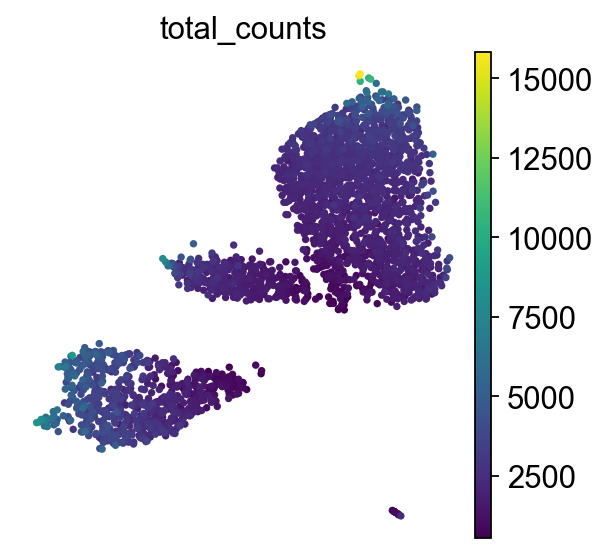

In [19]:
sc.pl.umap(adata, color="total_counts")